In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize': (12, 5)}, palette='colorblind')

RANDOM_SEED = 8927
np.random.seed(286)

### 10E1.
*If an event has probability 0.35, what are the log-odds of this event?*

In [2]:
sp.special.logit(0.35)

-0.6190392084062235

### 10E2.
*If an event has log-odds 3.2, what is the probability of this event?*

In [3]:
sp.special.expit(3.2) # in scipy, expit is the inverse of logit (aka logistic)

0.9608342772032357

### 10E3.
*Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about the proportional change in odds of the outcome?*

If a unit-change in a predictor increases the log-odds (the scale on which logistic regressions parameters live) of the outcome by 1.7, then this implies that the odds are multiplied by:

In [4]:
np.exp(1.7)

5.4739473917272

This is a proportional increase of 5.5 in the odds of the outcome, i.e a 275% increase in the odds.

### 10E4.
*Why do Poisson regressions sometimes require the use of an offset? Provide an example?*

An offset is used in a Poisson regression when the outcome variable is observed on different periods of time. For instance, 75% of the observations are on a daily-basis, while 25% are on a montly basis. Here, the offset would be about 30 days, and would allow to model these two periods on the same scale.

### 10M1.
*As explained in the chapter, binomial data can be organized in aggregated and disaggregated forms, without any impact on inference. But the likelihood of the data does change when the data are converted between the two formats. Can you explain why?*

**Disaggregated version**: each row of the data is a trial, resulting in an observation of either 1 (success) or 0 (failure). The likelihood then is a Bernoulli distribution, which describes the probability p of getting a success for a given trial - like the probability of getting a non-broken Kinder Bueno when opening one.

**Aggregated version**: each row of the data is now a count of the successes we got for a given number n of trials - like the number of non-broken Kinder Buenos we got while opening (and hopefully eating) a large number of them. In other words, this is an aggregation of Bernoulli trials with probability p. This generalization of the Bernoulli is called a Binomial distribution, which is entirely determined by the number n of trials and the probability p of success.

### 10M2.
*If a coefficient in a Poisson regression has value 1.7, what does this imply about the change in the outcome?*

Poisson regression parameters being on the log scale, we have to exponentiate them to interpret the proportional change they imply on the outcome scale:

In [5]:
np.exp(1.7)

5.4739473917272

### 10M3.
*Explain why the logit link is appropriate for a binomial generalized linear model.*

If our goal is to model the p parameter of a binomial likelihood, then this parameter is on [0,1], while a linear model (a + bx) is on the real line [-inf, +inf]. The logit function - $logit(p) = log\left(\frac{p}{1-p}\right)$ - allows to transcribe this proportion p on the real line. Note then that logit(0) = -inf, logit(0.5) = 0 and logit(1) = +inf. And logit(p) is not defined for p<0 or p>1.

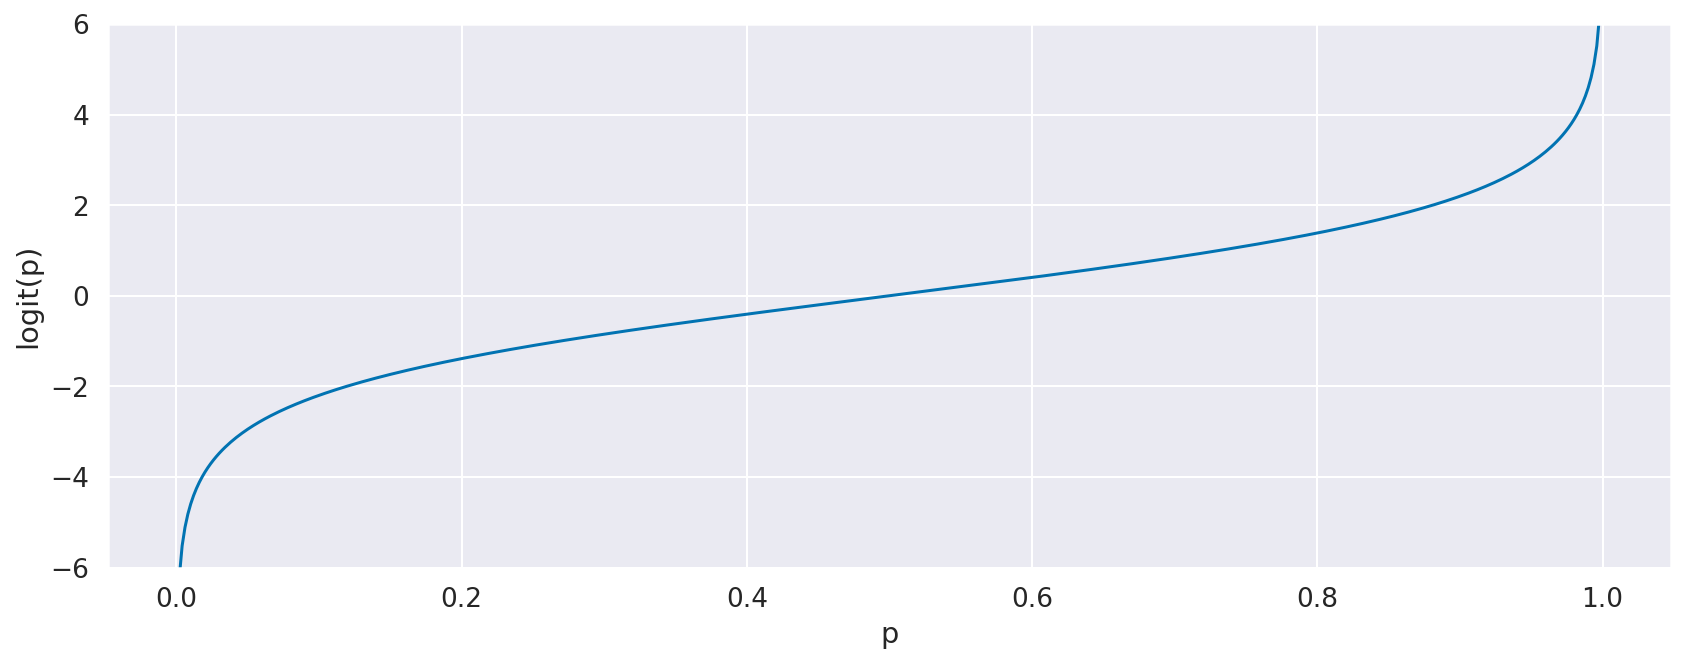

In [6]:
x = np.linspace(0, 1, 501)
y = sp.special.logit(x)
plt.figure(figsize=(14, 5))
plt.plot(x, y)
plt.ylim(-6, 6)
plt.xlabel('p')
plt.ylabel('logit(p)');

### 10M4.
*Explain why the log link is appropriate for a Poisson generalized linear model.*

Our goal is to model the lambda parameter of the Poisson likelihood. This parameter is on ]0, +inf], while a linear model (a + bx) is on the real line [-inf, +inf]. The log function allows to transcribe lambda on the real line.

### 10M5.
*What would it imply to use a logit link for the mean of a Poisson generalized linear model? Can you think of a real research problem for which this would make sense?*

The mean of a Poisson likelihood is, by definition, > 0, but logit is only defined on [0,1]. So, using a logit link for the mean of a Poisson GLM would bound that mean between ]0,1]. With the addition of one more parameter however, it could bound it to lie between zero and any arbitrary maximum:

$log\frac{\mu}{M-\mu} = \alpha + \beta x$

where M is a parameter that determines the maximum expected count. 

In practice you never see this link, because if a count variable can reach
a maximum, it is usually more appropriate to use a binomial likelihood together with the logit link. Remember, the premise with a Poisson likelihood is that it is really binomial, but the probability is very low and the number of trials very large. So any theoretical maximum count is never reached in the data.

Using the logit link with a Poisson could make sense if you have reason to think that the in uence of predictors on the mean diminishes eventually.  at is, if you want to stop the exponential growth.

### 10M6.
*State the constraints for which the binomial and Poisson distributions have maximum entropy. Are the constraints different at all for binomial and Poisson? Why or why not?*

The binomial distribution has maximum entropy when each trial must result in one of two events and the expected value (usually denoted $p$) is constant.

When a binomial has a very small expected probability $p$ and a very large (or even unknown) number of trials $n$, then it converges to a Poisson distribution. Being a special case of the binomial, it has maximum entropy under exactly the same constraints.

### 10H1.
*Use map to construct a quadratic approximate posterior distribution for the chimpanzee model that includes a unique intercept for each actor, m10.4 (page 299).*

*Compare the quadratic approximation to the posterior distribution produced instead from MCMC.*

*Can you explain both the differences and the similarities between the approximate and the MCMC distributions?*

Related to R and map. See code 10.14 in chapter 10 notebook for model specification and MCMC estimation in PyMC3

### 10H2.
*Use WAIC to compare the chimpanzee model that includes a unique intercept for each actor, m10.4 (page 299), to the simpler models fit in the same section*

In [7]:
d = pd.read_csv('../Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1


Intercept-only model (m10.1):

In [8]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1039.50draws/s]


Model predicting lever pulls using only prosoc_left (m10.2):

In [9]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 552.42draws/s]


Model including interaction between prosoc_left and condition (m10.3):

In [10]:
with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left + bpC * d.condition * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 418.51draws/s]


Model including interaction between prosoc_left and condition, and unique intercept for each actor (m10.4):

In [11]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + bp * d.prosoc_left + bpC * d.condition * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(1000, tune=1000, cores=2, nuts_kwargs={"target_accept": .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:23<00:00, 171.05draws/s]


In [12]:
comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2,
                      model_10_3 : trace_10_3,
                      model_10_4 : trace_10_4})

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3', 'm10.4'])
comp_df = comp_df.set_index('model')
comp_df

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/anaconda/envs/stat-rethink-pymc3/lib/py

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.4,530.05,8.43,0,1,19.93,0,0
m10.2,680.6,2.05,150.55,0,9.35,19.2,0
m10.3,682.38,3.02,152.32,0,9.48,19.15,0
m10.1,688.06,1.06,158.01,0,7.04,19.88,0


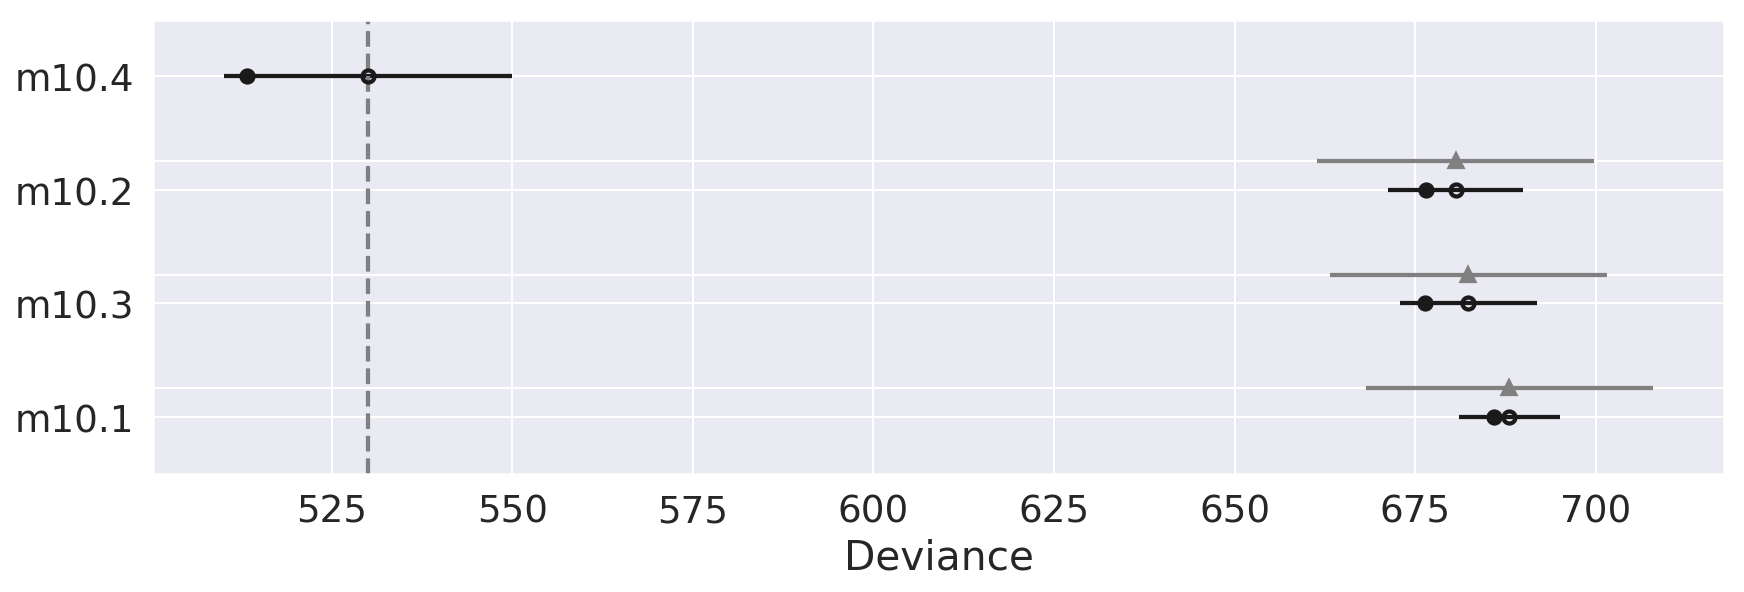

In [13]:
pm.compareplot(comp_df, figsize=(12, 4));

Based on information criteria, the most complex model looks clearly better than the simpler ones. This is a result of the variation among actors, which dwarfs the variation arising from treatment. Since only model m10.4 recognizes the variation among actors, it does much better in sample. It does so much better in sample, that even after accounting for the expected penalty out-of-sample, it still is expected to out-perform the other simpler models.

The caveat here is that this comparison only applies to predicting new observations for the same chimpanzees. For new chimpanzees, we couldn’t use their individual intercepts to make predictions. We could use the variation among chimpanzees to calibrate our predictions, though. But to do that we’ll need to actually estimate the variation itself. That will wait until the end of Chapter 12.

### 10H3.
*The data contained in eagles.csv are records of salmon pirating attempts by Bald Eagles in Washington State. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the "victim" and the thief the "pirate". Use the available data to build a binomial GLM of successful pirating attempts.*

*Consider the following model:*

$y_{i} \sim Binomial(n_{i}, p_{i})$

$log\left(\frac{p_{i}}{1-p_{i}}\right) = \alpha + \beta_{P}P_{i} + \beta_{V}V_{i} + \beta_{A}A_{i}$

$\alpha \sim Normal(0, 10)$

$\beta_{P} \sim Normal(0, 5)$

$\beta_{V} \sim Normal(0, 5)$

$\beta_{A} \sim Normal(0, 5)$

where:

-  $y$ is the number of successful attempts
-  $n$ is the total number of attempts
-  $P$ is a dummy variable indicating whether or not the pirate had large body size
-  $V$ is a dummy variable indicating whether or not the victim had large body size
-  and finally $A$ is a dummy variable indicating whether or not the pirate was an adult

*Fit the model above to the eagles data and interpret the estimates* 

*[NB: the difference between map and map2stan is related to the rethinking package, not to PyMC - we directly fit using MCMC]*

In [14]:
d = pd.read_csv('../Data/eagles.csv', sep=";")

# Turn into dummies and select corresponding encoding
dummies = pd.get_dummies(d[["P", "A", "V"]]).iloc[:, ::2]
dummies.columns = ["P", "A", "V"]

d = d[["y", "n"]].join(dummies)
d

,y,n,P,A,V
0,17,24,1,1,1
1,29,29,1,1,0
2,17,27,1,0,1
3,20,20,1,0,0
4,1,12,0,1,1
5,15,16,0,1,0
6,0,28,0,0,1
7,1,4,0,0,0


In [15]:
with pm.Model() as eagles_model:
    # Priors
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 5)
    bv = pm.Normal('bv', 0, 5)
    ba = pm.Normal('ba', 0, 5)
    
    #Linear model
    p = pm.math.invlogit(a + bp * d.P + bv * d.V + ba * d.A)
    
    #Likelihood
    pirated_salmons = pm.Binomial('pirated_salmons', d.n, p, observed=d.y)

    # Inference
    trace_eagles = pm.sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

pm.summary(trace_eagles, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ba, bv, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:13<00:00, 301.83draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.62,0.70,0.02,-0.47,1.76,1141.22,1.0
bp,4.64,0.96,0.03,3.15,6.09,868.43,1.0
bv,-5.02,1.05,0.04,-6.65,-3.34,840.51,1.0
ba,1.15,0.55,0.01,0.23,1.98,1239.00,1.0


/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


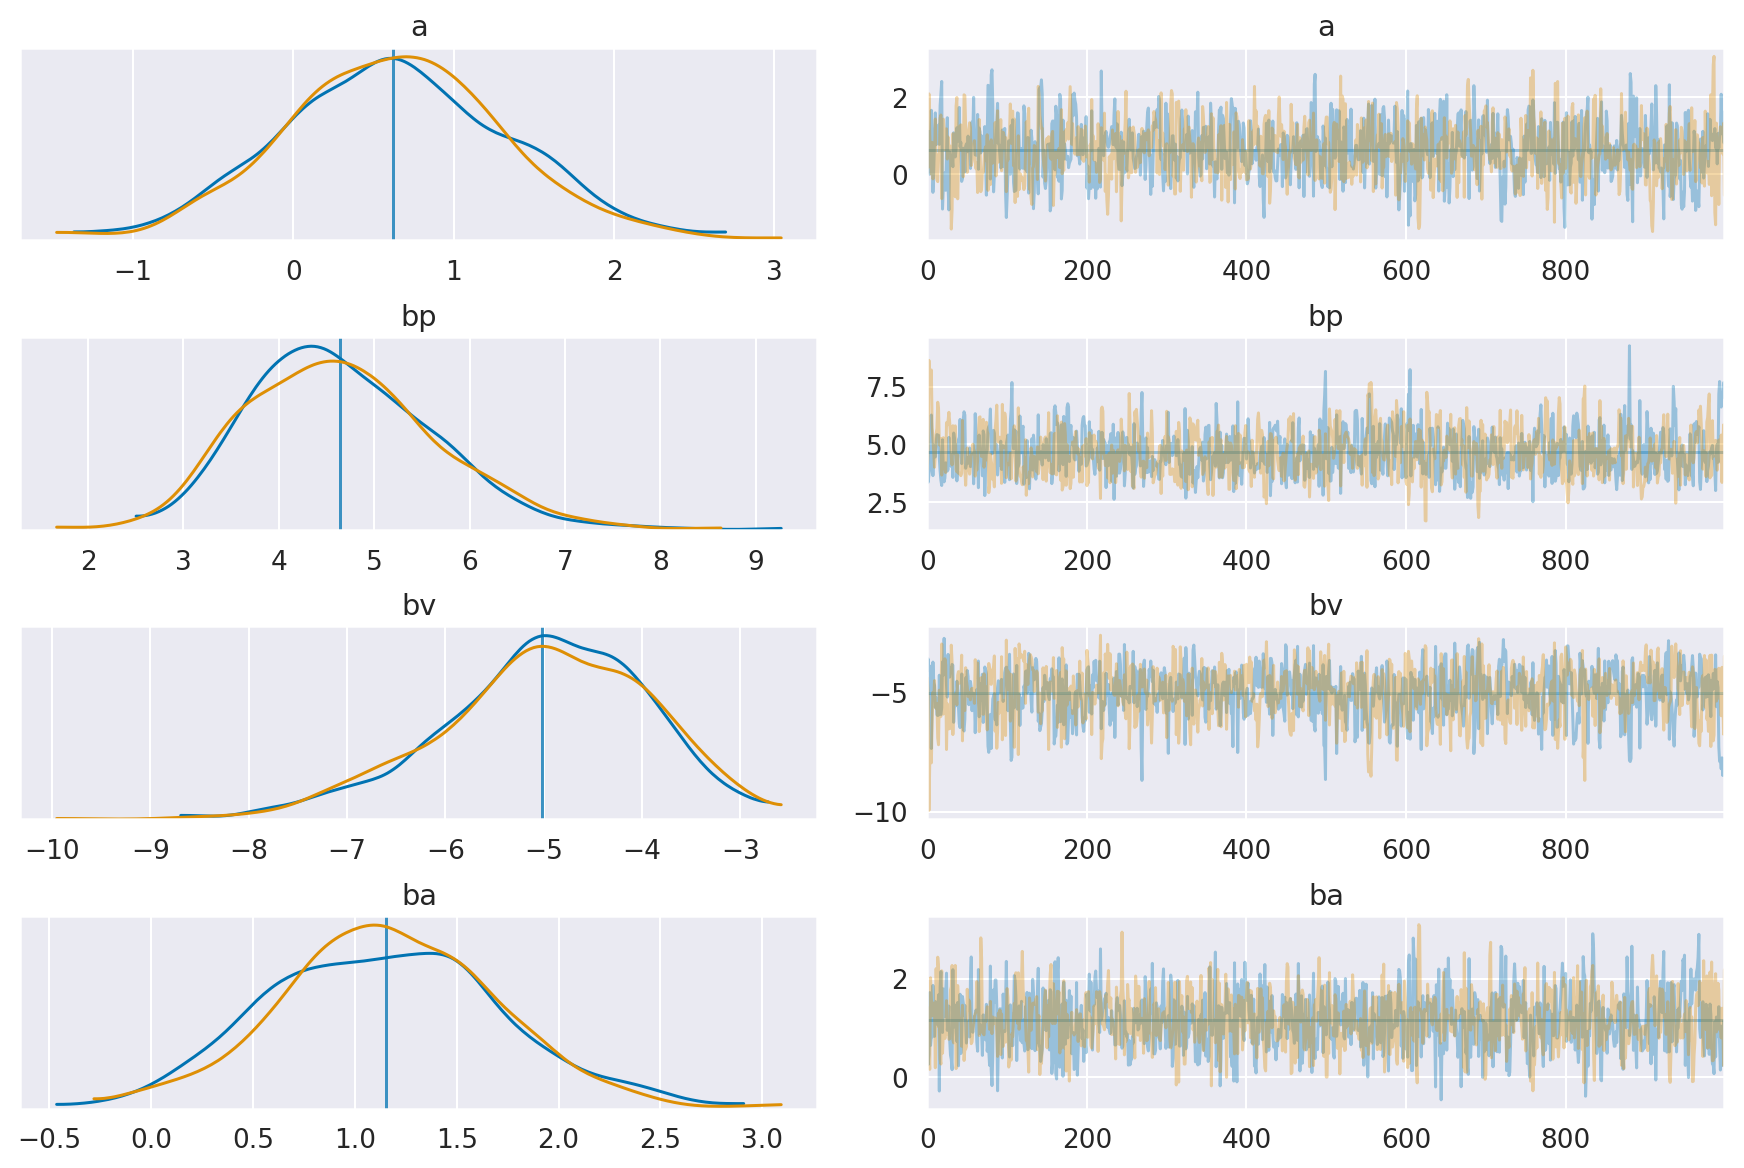

In [16]:
# overlay posterior means
lines = tuple((param, {}, val) for param, val in pm.summary(trace_eagles)['mean'].to_dict().items())
az.plot_trace(trace_eagles, lines=lines);

The parameters estimates are on the log-odds scale and only indicate the relative effect on the outcome, not the absolute effect (in a GLM, all parameters interact). As a first impression though:
- the intercept $a$ indicates the probability of a successful attempt for a pirate when all of the predictors are at zero. So that means a small immature pirate against a small victim has a probability of success of $logistic$(0.62) = 0.66.
- $b_{a}$ has a somewhat positive effect on the outcome (average proportional increase of $exp$(1.15)=3.13 in the odds), but the adulthood of the pirate doesn't seem to be as important as its body size or the one of the victim
- Indeed, $b_{p}$ and $b_{v}$ seem to have respectively a large positive (4.6) and negative (-5.0) effect on the probability of success - the larger the pirate/victim, the bigger/smaller the probability of the salmon being stolen.

It's easy to compute the effect on the outcome scale: as the predictors are all indicator variables, the slopes estimates just change the intercept for the log-odds. So for example, the probability that a large immature pirate succeeds against a small victim would be: $logistic$(0.62 + 4.64) = 0.99 (the large pirate is almost certain to succeed, according to the model). To get the absolute effect, you have to generate such predictions for all the combinations, as we'll do now.

*Compute and display both the predicted **probabilty** of success and its 89% interval for each row (i) in the data, as well as the predicted succes **count** and its 89% interval. What different information does each type of posterior prediction provide?*

In [17]:
# Predicted probability of success for each row
predictors = d[["P", "A", "V"]]
post = pm.trace_to_dataframe(trace_eagles)
predicted = pd.DataFrame(index=[f"{p}-{a}-{v}" for p, a, v in zip(d.P.astype(str), d.A.astype(str), d.V.astype(str))],
                        columns=["mean", "low", "high"], dtype=float)

# Compute probability of success from parameters and predictors:
for i in predictors.index:
    probs = sp.special.expit(post["a"] + \
                             post["bp"] * predictors.loc[i, "P"] + \
                             post["ba"] * predictors.loc[i, "A"] + \
                             post["bv"] * predictors.loc[i, "V"])
    predicted.iloc[i]["mean"] = np.mean(probs)
    predicted.iloc[i][["low", "high"]] = pm.hpd(probs, alpha=.11)

    predicted.index.name = "P-A-V"
predicted["success_obs"] = (d.y / d.n).values
predicted

,mean,low,high,success_obs
P-A-V,,,,
1-1-1,0.792272,0.673918,0.901717,0.708333
1-1-0,0.997299,0.994242,0.999963,1.000000
1-0-1,0.559672,0.417438,0.695965,0.629630
1-0-0,0.991452,0.981097,0.999887,1.000000
0-1-1,0.053247,0.001192,0.108079,0.083333
0-1-0,0.840552,0.734825,0.958230,0.937500
0-0-1,0.018093,0.000298,0.038591,0.000000
0-0-0,0.636967,0.409478,0.875085,0.250000


In [18]:
# Predicted counts of success for each row
ppc = pm.sample_posterior_predictive(trace_eagles, model=eagles_model, random_seed=RANDOM_SEED)['pirated_salmons']
# sample_posterior_predictive returns samples from the posterior, with the 8 possible combinations of P, A and V as seen in the original data
ppc = pd.DataFrame(data=ppc, columns=predicted.index)
ppc.head()

100%|██████████| 2000/2000 [00:04<00:00, 487.75it/s]


P-A-V,1-1-1,1-1-0,1-0-1,1-0-0,0-1-1,0-1-0,0-0-1,0-0-0
0,20,29,15,20,1,16,0,3
1,16,29,21,20,1,8,0,3
2,16,28,19,17,1,13,0,2
3,18,29,10,20,3,13,0,1
4,19,29,14,19,0,10,1,3


In [19]:
pred_counts = pd.DataFrame(index=ppc.columns, columns=["mean", "low", "high"], dtype=float)

for row in pred_counts.index:
    pred_counts.loc[row, ["low", "high"]] = pm.hpd(ppc.loc[:, row], alpha=.11)

pred_counts["mean"] = ppc.mean()
pred_counts

,mean,low,high
P-A-V,,,
1-1-1,19.0190,15.0,23.0
1-1-0,28.9295,29.0,29.0
1-0-1,15.0540,9.0,20.0
1-0-0,19.8165,19.0,20.0
0-1-1,0.6640,0.0,2.0
0-1-0,13.4430,11.0,16.0
0-0-1,0.5060,0.0,1.0
0-0-0,2.5570,1.0,4.0


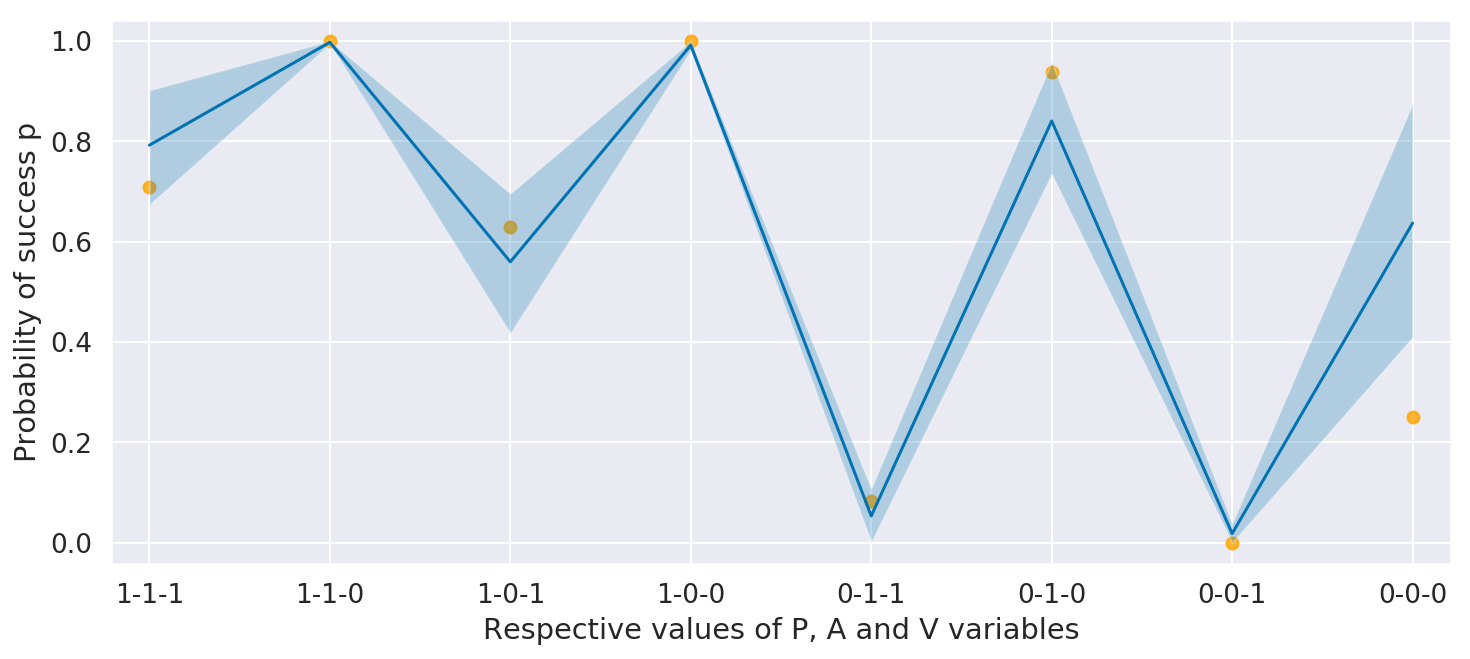

In [20]:
ticks = range(8)
plt.figure(figsize=(12,5))

plt.scatter(predicted.index, predicted.success_obs, color='orange', alpha=0.8)
predicted['mean'].plot()
plt.fill_between(ticks, predicted['low'], predicted['high'], alpha=0.25)

plt.xticks(ticks)
plt.xlabel("Respective values of P, A and V variables")
plt.ylabel("Probability of success p")

plt.autoscale(tight=False)
plt.margins(.03);

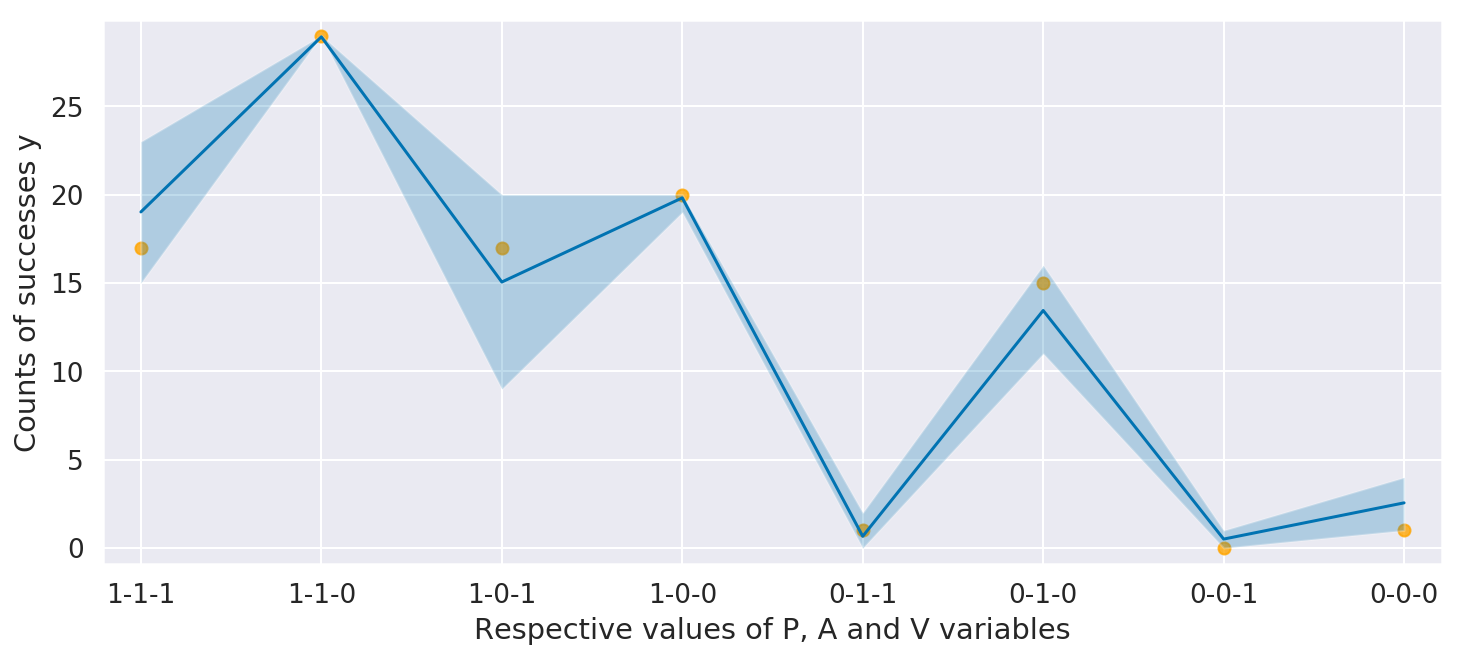

In [21]:
plt.figure(figsize=(12,5))
plt.scatter(pred_counts.index, d.y, color='orange', alpha=0.8)
pred_counts['mean'].plot()
plt.fill_between(ticks, pred_counts['low'], pred_counts['high'], alpha=0.25)
plt.xticks(ticks)
plt.xlabel("Respective values of P, A and V variables")
plt.ylabel("Counts of successes y")
plt.autoscale(tight=False)
plt.margins(.03);

Both posterior predictions show there is a lot of variation between the different categories and their respective uncertainty. This also allows us to see the effect of the predictors on the outcome: the body size of the victim/pirate does have the biggest effect on the probability of success. Adulthood has a milder effect, insofar as it doesn't fully compensate a smaller body size.

But what’s different? The biggest difference is probably that the first plot (proportions) makes the probabilities more comparable, because it ignores the sample size for each case on the horizontal axis. This has the advantage of showing, for example, that 0-0-0 (small-immature-small) attempts are predicted to be somewhat successful, even though only 4 of them were observed. The second plot (counts), in contrast, makes it hard to see the differing probabilities, because samples size varies so much across cases.

On the other hand, the count plot has the advantage of showing additional uncertainty that arises from the binomial process. Inspect the 0-0-0 (SIS) case again, for example. The observed proportion of SIS successes is outside and below the probability interval (first plot). However, in the count plot, the model can accommodate the SIS cases, due to additional uncertainty arising from the binomial process. In other words, an additional level of stochasticity is factored into the count plot, and so in total looking also at counts might be necessary to seriously critique the model.

*Now try to improve the model. Consider an interaction between the pirate's size and age (immature or adult). Compare this model to the previous one, using WAIC. Interpret*

In [22]:
with pm.Model() as eagles_inter_model:
    # Priors
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 5)
    bap = pm.Normal('bap', 0, 5)
    ba = pm.Normal('ba', 0, 5)
    bv = pm.Normal('bv', 0, 5)
    
    #Linear model
    p = pm.math.invlogit(a + bp*d.P + bap*d.A*d.P + ba*d.A + bv*d.V)
    
    #Likelihood
    pirated_salmons = pm.Binomial('pirated_salmons', d.n, p, observed=d.y)

    # Inference
    trace_eagles_inter = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

pm.summary(trace_eagles_inter, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bv, ba, bap, bp, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:26<00:00, 222.44draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.81,1.05,0.04,-2.58,0.75,796.02,1.0
bp,6.56,1.39,0.05,4.38,8.70,682.89,1.0
bap,-3.00,1.35,0.05,-5.28,-1.00,743.59,1.0
ba,3.44,1.24,0.05,1.63,5.50,718.11,1.0
bv,-5.23,1.09,0.04,-6.81,-3.43,744.49,1.0


In [23]:
comp_df = pm.compare({eagles_model : trace_eagles,
                      eagles_inter_model : trace_eagles_inter})

comp_df.loc[:,'model'] = pd.Series(['eagles_model', 'eagles_inter_model'])
comp_df = comp_df.set_index('model')
comp_df

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/anaconda/envs/stat-rethink-pymc3/lib/pytho

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
eagles_inter_model,20.3,1.88,0,1,5.49,0,1
eagles_model,30.26,4.97,9.96,0,7.66,3.22,1


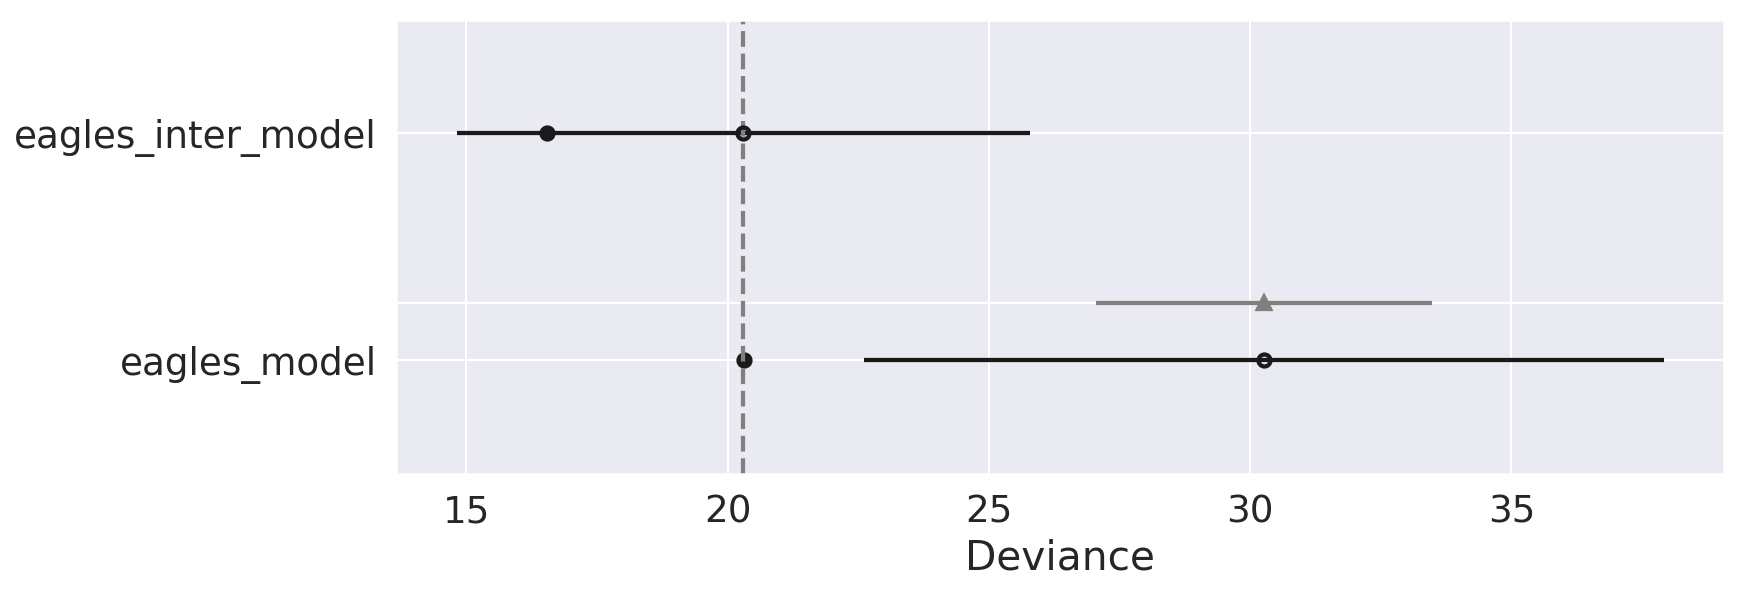

In [24]:
pm.compareplot(comp_df, figsize=(12, 4));

The interaction model looks clearly better according to WAIC: even doubling the difference's standard error to get a 95% interval, the complex model would still be ahead. So, although it has more actual parameters than the simple model, it has 2x less effective parameters and overfits the sample less.

How can we interpret it? The effect of all slope parameters is stronger now, and there is a strong negative interaction between the pirate's size and age: when the pirate is both large and adult, the log-odds are smaller. That seems weird. But remember the main effects for size and age are also turned on when a pirate is both large and adult.

So what does this mean? The influence of pirate's size on success now depends on pirate's age, and the parameter $b_{ap}$ defines the strength of this dependency. So the MAP slope relating pirate's size to probability of success for adult pirates is: 
$b_{p} + b_{ap} \times 1 = 6.56 - 3.00 = 3.56$. And for immature pirates: $b_{p} + b_{ap} \times 0 = 6.56$

So a large body size is more helpful to an immature pirate than to an adult pirate. This can be due to a bigger baseline success rate for adults: perhaps because they are already stronger, clever or more experienced, adult pirates already succeed more often. Thus, being bigger has a weaker marginal benefit than when you're a young pirate.

Interactions models are hard to interpret with just a table of estimates though - best to plot the implied predictions:

In [25]:
predictors = d[["P", "A", "V"]]
post = pm.trace_to_dataframe(trace_eagles_inter)
predicted = pd.DataFrame(index=[f"{p}-{a}-{v}" for p, a, v in zip(d.P.astype(str), d.A.astype(str), d.V.astype(str))],
                        columns=["mean", "low", "high"], dtype=float)
# Compute probability of success from parameters and predictors:
for i in predictors.index:
    probs = sp.special.expit(post["a"] + \
                             post["bp"] * predictors.loc[i, "P"] + \
                             post["bap"] * predictors.loc[i, "A"] * predictors.loc[i, "P"] + \
                             post["ba"] * predictors.loc[i, "A"] + \
                             post["bv"] * predictors.loc[i, "V"])
    predicted.iloc[i]["mean"] = np.mean(probs)
    predicted.iloc[i][["low", "high"]] = pm.hpd(probs, alpha=.11)
predicted.index.name = "P-A-V"
predicted["success_obs"] = (d.y / d.n).values
predicted

,mean,low,high,success_obs
P-A-V,,,,
1-1-1,0.714574,0.565823,0.842696,0.708333
1-1-0,0.996335,0.991781,0.999975,1.000000
1-0-1,0.622872,0.489406,0.780336,0.629630
1-0-0,0.994554,0.987545,0.999987,1.000000
0-1-1,0.092101,0.002582,0.182031,0.083333
0-1-0,0.914501,0.839247,0.996030,0.937500
0-0-1,0.005323,0.000010,0.012297,0.000000
0-0-0,0.344030,0.029789,0.614198,0.250000


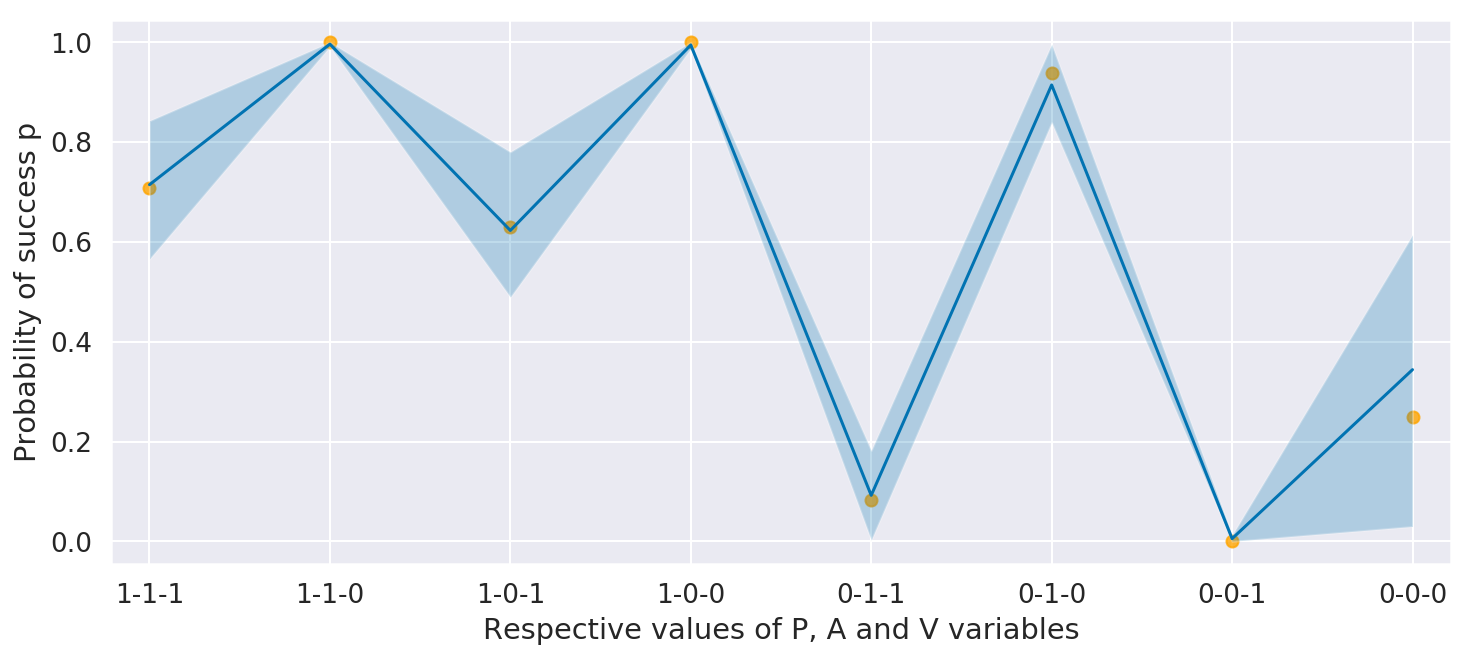

In [26]:
ticks = range(8)
plt.scatter(predicted.index, predicted.success_obs, color='orange', alpha=0.8)
predicted['mean'].plot(figsize=(12,5))
plt.fill_between(ticks, predicted['low'], predicted['high'], alpha=0.25)
plt.xticks(ticks)
plt.xlabel("Respective values of P, A and V variables")
plt.ylabel("Probability of success p")
plt.autoscale(tight=False)
plt.margins(.03);

### 10H4.
*The data contained in salamanders.csv are counts of salamanders (Plethodon elongatus) from 47 different 49m2 plots in northern California. The column SALAMAN is the count in each plot, and the columns PCTCOVER and FORESTAGE are percent of ground cover and age of trees in the plot, respectively. You will model SALAMAN as a Poisson variable.*

*(a) Model the relationship between density and percent cover, using a log-link (same as the example in the book and lecture). Use weakly informative priors of your choosing. Then plot the expected counts and their 89% interval against percent cover. In which ways does the model do a good job? In which ways does it do a bad job?*

In [27]:
d = pd.read_csv('../Data/salamanders.csv', sep=";")
# Standardize predictors to help sampling
for c in ["PCTCOVER", "FORESTAGE"]:
    d[c] = (d[c] - d[c].mean())/d[c].std()
d.head()

,SITE,SALAMAN,PCTCOVER,FORESTAGE
0,1,13,0.727323,0.760627
1,2,11,0.755274,-0.417586
2,3,11,0.867079,1.959512
3,4,9,0.811176,-0.541609
4,5,8,0.839127,-0.650129


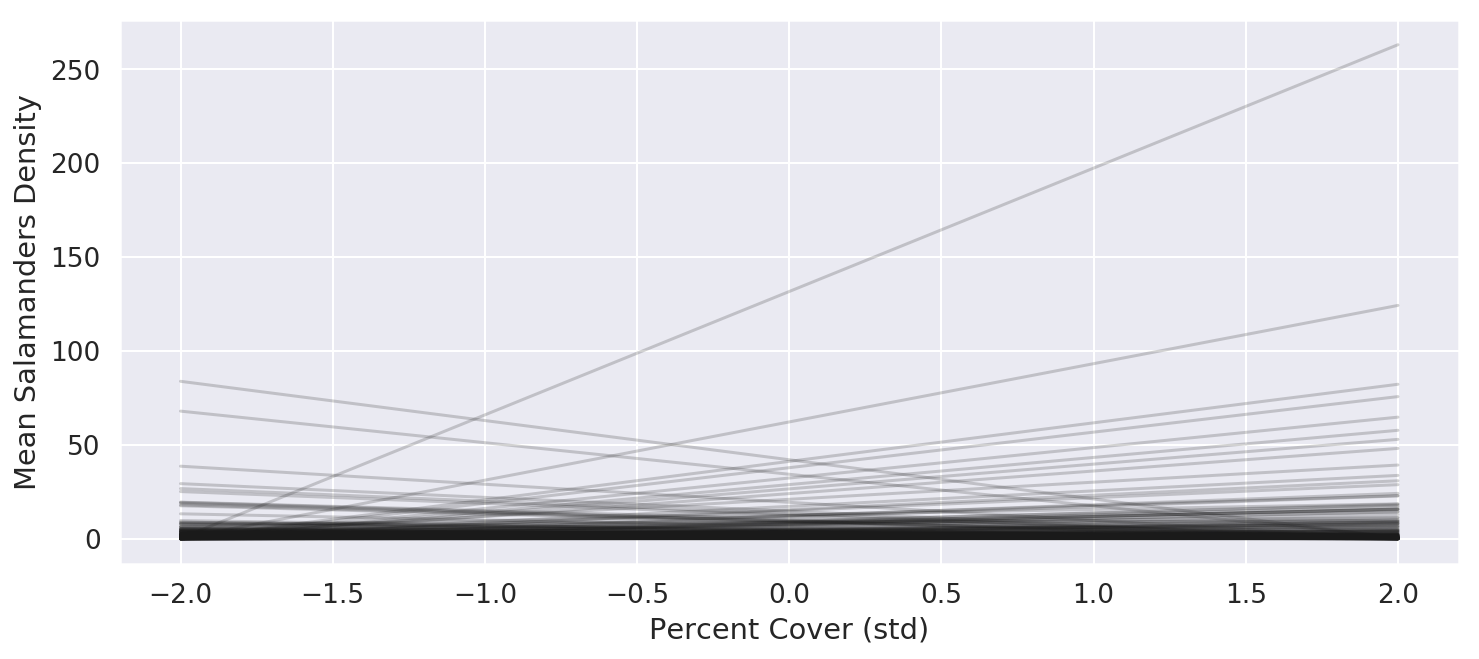

In [28]:
# Prior predictive checks, to see if prior choice makes sense
a_s = pm.Normal.dist(mu=0., sd=1.).random(size=200)
bp_s = pm.Normal.dist(mu=0., sd=.8).random(size=200)

plt.figure(figsize=(12,5))
for y_s in zip(np.exp(a_s - 2*bp_s), np.exp(a_s + 2*bp_s)):
    plt.plot([-2, 2], y_s, color='k', alpha=.2)
plt.xlabel("Percent Cover (std)")
plt.ylabel("Mean Salamanders Density");

In [29]:
with pm.Model() as salam_model:
    # The exp link makes the lambda really big, really quickly, so need strongly regularizing priors:
    a = pm.Normal('a', 0., 1.)
    bp = pm.Normal('bp', 0., 0.8)
    
    # Casting predictor to theano shared variables for out of sample predictions later
    pctcover = pm.Data('pctcover', d.PCTCOVER)
    lam = pm.math.exp(a + bp*pctcover)
    
    salam_density = pm.Poisson('salam_density', mu=lam, observed=d.SALAMAN)
    trace_salam = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post = pm.trace_to_dataframe(trace_salam)
pm.summary(trace_salam, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:08<00:00, 680.29draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.44,0.14,0.01,0.21,0.66,644.48,1.0
bp,1.12,0.17,0.01,0.84,1.38,655.91,1.0


The estimate for $b_{p}$ is positive, which means counts are predicted to increase with cover. But by how much? Hard to say until you convert back to the count scale. So let's plot the predictions!

100%|██████████| 2000/2000 [00:05<00:00, 340.44it/s]


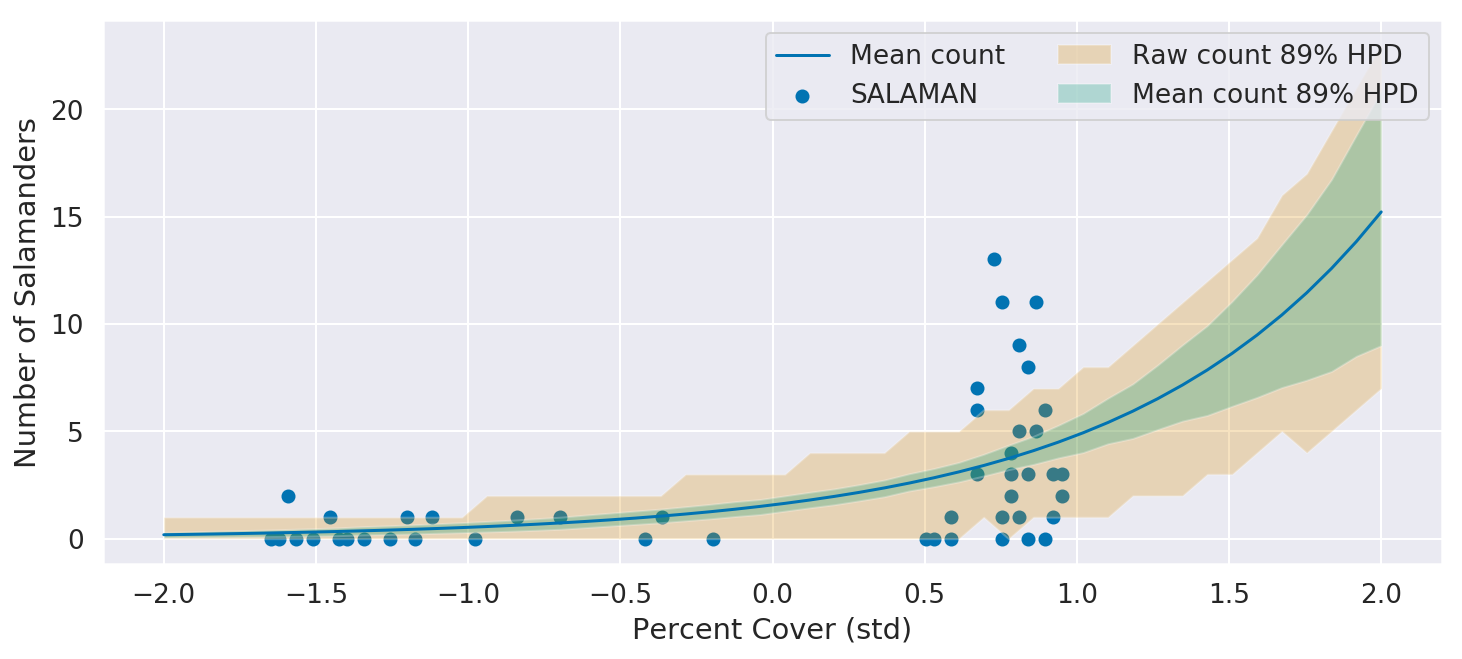

In [30]:
# define values to compute OOS predictions over
pctcover_seq = np.linspace(-2, 2)

# lambda calcs (pymc doesn't have a link function)
lambdas = pd.DataFrame(index = pctcover_seq)
lambdas.index.name = 'pctcover_seq'
for pct in pctcover_seq:
    lambdas.loc[pct, 'mean'] = np.mean(np.exp(post['a'] + post['bp']*pct))
    lambdas.loc[pct, 'low'], lambdas.loc[pct, 'high'] = pm.hpd(np.exp(post['a'] + post['bp']*pct), alpha=0.11)

# outcome calcs
with salam_model:
    pm.set_data({'pctcover': pctcover_seq})
    salam_density = pm.sample_posterior_predictive(trace_salam, random_seed=RANDOM_SEED)['salam_density']
salam_pi = pm.hpd(salam_density, alpha=0.11)

# plot
plt.figure(figsize=(12,5))

plt.scatter(d.PCTCOVER, d.SALAMAN)
plt.fill_between(pctcover_seq, salam_pi[:, 0], salam_pi[:, 1], alpha=0.25, label="Raw count 89% HPD")
plt.fill_between(pctcover_seq, lambdas['low'], lambdas['high'], alpha=0.25, label="Mean count 89% HPD")
plt.plot(pctcover_seq, lambdas['mean'], label="Mean count")

plt.xlabel("Percent Cover (std)")
plt.ylabel("Number of Salamanders")
plt.legend(ncol=2);

The model captures quite well the positive relationship between percent cover and number of salamanders - the more cover, the more salamanders on average. But it seems that this relationship stops being exponential at some point (around 0.8 percent cover), causing the model (1) to understimate the possible counts around 0.8 percent cover, (2) to predict unplausibly large and uncertain counts of salamanders for large values of percent cover.

Also, there seem to be two clusters in the data: plots with negative percent cover have low counts and no obvious increasing trend, while those with positive percent cover have more dispersed and higher counts. Maybe other variables could help the model explain these clusters.

*(b) Can you improve the model by using the other predictor, FORESTAGE? Try any models you think useful. Can you explain why FORESTAGE helps or does not help with prediction?*

In [31]:
with pm.Model() as second_salam_model:
    a = pm.Normal('a', 0., 1.)
    bp = pm.Normal('bp', 0., 0.8)
    bf = pm.Normal('bf', 0., 0.8)
    
    # Casting predictors to theano shared variables for out of sample predictions later
    pctcover = pm.Data('pctcover', d.PCTCOVER)
    forestage = pm.Data('forestage', d.FORESTAGE)
    lam = pm.math.exp(a + bp*pctcover + bf*forestage)
    
    salam_density = pm.Poisson('salam_density', mu=lam, observed=d.SALAMAN)
    trace_salam_second = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_second = pm.trace_to_dataframe(trace_salam_second)
pm.summary(trace_salam_second, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bf, bp, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:10<00:00, 584.64draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.44,0.15,0.00,0.22,0.69,1157.78,1.0
bp,1.12,0.19,0.01,0.82,1.42,1171.00,1.0
bf,0.00,0.09,0.00,-0.13,0.16,1493.03,1.0


The estimate for $b_{f}$ is 0, with a small interval around it: there isn't much association between forest age and salamander density, while also controlling for percent cover.

Why doesn’t forest age help much? It certainly does improve predictions, in the absence of percent cover — check for yourself by fitting a model that includes only FORESTAGE as a predictor. If all we knew was forest age, it would be a good predictor. 

But compared to percent cover, forest age doesn’t help us at all. This is probably because the two predictors are correlated (their correlation is 0.63 after all), but the predictive ability of forest age arises just through its correlation with percent cover. That is to say, older forests also tend to have more cover. But it’s cover that the salamanders are seeking, and so they are found more in places with more cover. This is a misleading correlation, much like the Waffle House and divorce rate thing from Chapter 5.

In [32]:
import sys, IPython, scipy, matplotlib, platform
print(f"This notebook was created on a computer {platform.machine()}, using: "
      f"\nPython {sys.version[:5]}\nIPython {IPython.__version__}\nPyMC3 {pm.__version__}\nNumPy {np.__version__}"
      f"\nPandas {pd.__version__}\nSciPy {scipy.__version__}\nMatplotlib {matplotlib.__version__}\n")

This notebook was created on a computer x86_64, using: 
Python 3.7.3
IPython 7.5.0
PyMC3 3.7
NumPy 1.16.3
Pandas 0.24.2
SciPy 1.2.1
Matplotlib 3.0.3

